In [158]:
import sys
sys.path.append('C:/Users/Billy/Documents/PRISMO/Backtester')
from multiprocessing import Process
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import random
from mathCode.johansenMain import coint_johansen
from tqdm import tqdm_notebook
from IPython.display import clear_output
import itertools
import datetime
import os
from base_model_backtest import backtest
import random
from pandas_datareader import data as pdr
import logging
from pandas.plotting import register_matplotlib_converters
from functionSource import *
from operator import itemgetter
import quandl
from sklearn import preprocessing

register_matplotlib_converters()
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
plt.style.use(['ggplot'])
def APR(returns):
    ave = []
    for year in range(returns.index[0].year, returns.index[-1].year+1):
        annualReturns = returns.loc[returns.index<str(year+1)+'-01-01']
        annualReturns = annualReturns.loc[annualReturns.index>=str(year)+'-01-01']

        aveReturns = np.mean(annualReturns) 
        ave.append(aveReturns*252*100)
        

    return np.mean(ave)

def monotonicityMeasure(returns):
     # Start by counting how many points in the future returns are greater than the current
     # If its less than current, we want to emphasise that it's non monatonic in the long run and is a bad strategy
    # Check x chunks for monotonicity
    chunks = 50
    binWidth = int(len(returns)/chunks)
    
    totalCounter = 0
    monotonicCounter = 0
    for i in range(0,len(returns),binWidth):
        for j in range(i+chunks,len(returns),binWidth):
            
            if returns[j]>returns[i]:
                monotonicCounter +=1
            
            totalCounter+=1
    
    
    
    return monotonicCounter/totalCounter


def optimize(toTrade, delta_in = None, ve_in = None, plot = None):
    asset = toTrade[-1]
    toTrade = toTrade[:-1]
    
    if asset == 'OSRS':
        asset_a = toTrade[0]
        asset_b = toTrade[1]
        data = pd.read_csv('D:/Runescape_Market_Data.csv')
        data = pd.DataFrame(data.set_index(['ItemName','PriceDate'])['Price'])
        a = data.loc[([asset_a, asset_b],)].loc[asset_a]
        a.columns =[asset_a]
        b = data.loc[([asset_a, asset_b],)].loc[asset_b]
        b.columns = [asset_b]
        close_ = a.join(b, on='PriceDate').sort_index()
        print(toTrade, close_.head())
        
    if asset == 'ETF':
        data = pickle.load(open( "D:/PRISMO/historicalData/ETFSnobiasFINAL.pickle", "rb" ) )
        close = data.xs('CLOSE', axis = 1, level = 1)
        close_= close[toTrade].dropna()
    
    if asset == 'Stock':
        data = pickle.load(open( "D:/PRISMO/historicalData/Data/asx200nobiasFINAL.pickle", "rb" ) )
        close = data.xs('CLOSE', axis = 1, level = 1)
        close_= close[toTrade].dropna()

    
    if asset == 'ernie':
        df = pd.read_csv('D:/Machine_learning_finance/raw_data/ewaewcige.csv')
        df.set_index('Date',inplace=True)
        close = df
        close_ = close
        close = data.xs('CLOSE', axis = 1, level = 1)
        close_= close[toTrade].dropna()
    
    if asset == 'mexico':
        data = pickle.load(open('E:/data/mexico.csv','rb'))
        close = data.xs('CLOSE', axis = 1, level = 1)
        close_= close[toTrade].dropna()
        
    results=[]
    results.append(['delta','ve','cumret','sharpe','weightedCum','weightedSharpe'])
    ve_values = []
    delta_values = []
    for ve_ in range(1,10):
        order = round(0.1**(ve_+2), 12)
        for i in range(1,10):
            ve_values.append(round(i*order,12))
            delta_values.append(round(i*order,12))
            
            
    if delta_in is not None:
        delta_values = delta_in
    
    if ve_in is not None:
        ve_values = ve_in
        
    for delta in delta_values:
        for Ve in ve_values:
            close = close_
            #INIT
            yhatList = []
            QList= []
            eList=[]
            betaList = [np.matrix([[0],[0]])]
            R = np.zeros([len(toTrade),len(toTrade)])
            P = np.zeros([len(toTrade),len(toTrade)])
            y = []
            hedges = []
            Vw = delta/(1-delta)*np.diag(np.ones(len(toTrade)))

            for row in close.iterrows():
                #Extract x and y from the row, put them into numpy form. We include a constant for x so we can fit with a constant.
                x = np.matrix([[row[1][toTrade[0]]],[1]])
                y = np.matrix(row[1][toTrade[1]])

                ## 1 STEP AHEAD PREDICTION ##
                beta = betaList[-1]                                            # beta(t|t-1) = beta(t-1|t-1)
                R = P +Vw                                       #    R(t|t-1) = R(t-1|t-1) + Vw
                yhat = np.dot(x.T, beta)                                        #        yhat = x.beta
                e_t = y - yhat                                                  #        e(t) = y(t) - yhat(t)
                Q_t = np.dot( np.dot(x.T, R) , x ) +Ve               #        Q(t) = var(e(t)) = var(y(t) - yhat(t)) 
                #                                                                             = var(y(t)) + var(yhat(t)) + cov[y(t), yhat(t)]
                #                                                                             = x . R(t|t-1) + Ve


                ## UPDATE PARAMETERS ##
                K = np.dot(R, x) / Q_t                                                 # K is the kalman gain
                beta = beta + K*e_t                                                         # beta(t|t) = beta(t|t-1)+K(t)e(t)
                P = R - np.dot( np.dot(K, np.transpose(x)), R)               # We denote R(t|t) by P, and R(t|t-1) as R. R(t | t − 1) = cov(β(t) − βhat(t|t-1))

                #Add beta and predicted y values to arrays for storage
                betaList.append(beta)
                yhatList.append(yhat)

                #Form the hedge ratio as a float
                hedgeRatio = beta[0].tolist()[0][0]
                hedges.append(hedgeRatio)
                eList.append(e_t.tolist()[0][0])
                QList.append(Q_t.tolist()[0][0])

            close.loc[slice(None),'e'] = eList
            close.loc[slice(None),'Q'] = QList

            if np.mean(close['e'])>np.sqrt(np.mean(close['Q'])):
#                 print('means',np.mean(close['e']), np.sqrt(np.mean(close['Q'])))
    #             if the average error is greater than the average deviation the parameters are fucked. No point going further
                break


            close.loc[slice(None),'LongEntry'] = close['e']<-np.sqrt(close['Q'])
            close.loc[slice(None),'LongExit'] = close['e']>-np.sqrt(close['Q'])
            close.loc[slice(None),'ShortEntry'] = close['e']>np.sqrt(close['Q'])
            close.loc[slice(None),'ShortExit'] = close['e']<np.sqrt(close['Q'])
            ratios = hedges
            numUnitsLong = np.array([[np.nan]]*len(close))
            numUnitsShort = np.array([[np.nan]]*len(close))

            numUnitsLong[0] = 1
            numUnitsLong[np.array(close['LongEntry'])] = 1
            numUnitsLong[np.array(close['LongExit'])] = 0

            numUnitsShort[0] = 1
            numUnitsShort[np.array(close['ShortEntry'])] = -1
            numUnitsShort[np.array(close['ShortExit'])] = 0

            close.loc[slice(None),'short'] = numUnitsShort
            close.loc[slice(None),'short'].fillna('ffill')
            close.loc[slice(None),'long'] =  numUnitsLong
            close.loc[slice(None),'long'].fillna('ffill')

            close.loc[slice(None),'numUnits'] = close['long'] + close['short']

            close.loc[slice(None),'numUnits'+toTrade[0]] = -close['numUnits']*ratios
            close.loc[slice(None),'numUnits'+toTrade[1]] = close['numUnits']

            close.loc[slice(None),'positions'+toTrade[0]] = close['numUnits'+toTrade[0]]*close[toTrade[0]]
            close.loc[slice(None),'positions'+toTrade[1]] = close['numUnits'+toTrade[1]]*close[toTrade[1]]
            
            comission = (close['positions'+toTrade[0]].shift(1)+close['positions'+toTrade[1]].shift(1))*0.0008
            comission = 0
            close.loc[slice(None),'pnl'] = close[toTrade[0]].pct_change()*(close['positions'+toTrade[0]].shift(1)) + close[toTrade[1]].pct_change()*(close['positions'+toTrade[1]].shift(1))-comission
            
           
            #need to make a date trade opened/closed feature for each returns
            
            close.loc[slice(None),'returns'] = (close['pnl'])/(np.abs(close['positions'+toTrade[0]]) +np.abs(close['positions'+toTrade[0]])).shift(1)

#             close.loc[slice(None),'returns']= close['returns'][close['returns']<0.1]
            
            sharpe = (np.mean(close['returns']))
            try:
                numTrades = len(close[close['numUnits']!=0])/2
#                 print('Number of Trades: ',numTrades)
                if numTrades > 50:
    #                 monotonicity = monotonicityMeasure(np.cumsum(close['returns'].fillna(0)))
                    monotonicity = 1
                    weightedSharpe = monotonicity*sharpe
                    weightedRet = monotonicity*np.cumsum(close['returns'].fillna(0)).iloc[-1]
                    if plot == True:
    #                         %matplotlib notebook

                        plt.plot(np.cumsum(close['returns'].fillna(0)))
                        plt.show()
                    print([delta, Ve,np.cumsum(close['returns'].fillna(0)).iloc[-1], sharpe, weightedRet, weightedSharpe])
                    results.append([delta, Ve,np.cumsum(close['returns'].fillna(0)).iloc[-1], sharpe, weightedRet, weightedSharpe])

            except Exception as e:
                print(e)
    pickle.dump(results, open('C:/Users/Billy/Documents/PRISMO/Backtester/optimizers/cointegration/results/'+flatten(toTrade)+'.pickle','wb'))
    return close

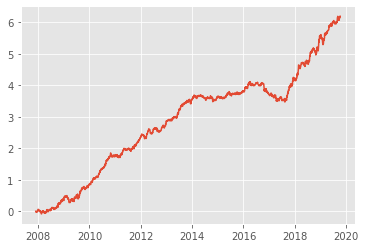

[4e-07, 2e-05, 6.190114056977967, 0.002374420428453382, 6.190114056977967, 0.002374420428453382]


In [94]:
strategy = optimize(['TLS.AX','SKC.AX','Stock'],[4e-07],[2e-05],True)

In [114]:
data = strategy[['returns',]].join(bigPappa).fillna(method='ffill').fillna(0)

In [58]:
# metadata = quandl.get_table("AUSBS/M", paginate=True,api_key='h8Pb4wW3eWuNu8emC6g6')
data = quandl.get_table("AUSBS/D", paginate=True,api_key='h8Pb4wW3eWuNu8emC6g6',series_id = batches[0] )

In [59]:
data

,series_id,date,value
None,,,
0,A3348642X,1982-04-01,347.5
1,A3348642X,1982-05-01,346.3
2,A3348642X,1982-06-01,345.9
3,A3348642X,1982-07-01,345.5
4,A3348642X,1982-08-01,346.4
5,A3348642X,1982-09-01,348.7
6,A3348642X,1982-10-01,353.4
7,A3348642X,1982-11-01,358.8
8,A3348642X,1982-12-01,364.2


In [71]:
bigPappa

date
1982-04-01     347.5
1982-05-01     346.3
1982-06-01     345.9
1982-07-01     345.5
1982-08-01     346.4
1982-09-01     348.7
1982-10-01     353.4
1982-11-01     358.8
1982-12-01     364.2
1983-01-01     367.7
1983-02-01     368.7
1983-03-01       369
1983-04-01     368.6
1983-05-01     369.7
1983-06-01     371.1
1983-07-01     373.2
1983-08-01     375.2
1983-09-01     376.4
1983-10-01     377.4
1983-11-01     379.3
1983-12-01     382.9
1984-01-01     388.6
1984-02-01     394.8
1984-03-01     400.2
1984-04-01     403.9
1984-05-01     406.2
1984-06-01     407.5
1984-07-01     408.3
1984-08-01       409
1984-09-01     410.5
               ...  
2017-05-01    3672.1
2017-06-01    3679.5
2017-07-01    3687.2
2017-08-01      3696
2017-09-01    3707.1
2017-10-01    3720.3
2017-11-01    3734.7
2017-12-01    3746.5
2018-01-01    3752.5
2018-02-01    3753.5
2018-03-01    3754.1
2018-04-01    3760.6
2018-05-01    3773.9
2018-06-01    3790.2
2018-07-01    3806.1
2018-08-01    3819.6
2018-09-

In [90]:
month  = metadata[metadata['month']==str(1)].series_id
batches = []
batch_len = 200
i = 0
bigPappa = None
while i * batch_len <len(month):
    print(i*batch_len, len(month))
    batches.append(month[i*batch_len:(i+1)*batch_len])
    data = quandl.get_table("AUSBS/D", paginate=True,api_key='h8Pb4wW3eWuNu8emC6g6',series_id = batches[-1])
    for batch in batches[-1]:
        data_temp = data.loc[data['series_id']==batch]
        if len(data_temp)>200:
            if bigPappa is None:
                bigPappa = pd.DataFrame(data.loc[data['series_id']==batch].set_index('date')).T.loc['value',].T
                bigPappa = pd.DataFrame(bigPappa)
                bigPappa.columns = [batch]

            else:
                temp = pd.DataFrame(data.loc[data['series_id']==batch].set_index('date').T.loc['value',].T)
                
                temp.columns = [batch]
                bigPappa = bigPappa.join(temp)
            
    i+=1

0 26693
200 26693
400 26693
600 26693
800 26693
1000 26693
1200 26693
1400 26693
1600 26693
1800 26693
2000 26693
2200 26693
2400 26693
2600 26693
2800 26693
3000 26693
3200 26693
3400 26693
3600 26693
3800 26693
4000 26693
4200 26693
4400 26693
4600 26693
4800 26693
5000 26693
5200 26693
5400 26693
5600 26693
5800 26693
6000 26693
6200 26693
6400 26693
6600 26693
6800 26693
7000 26693
7200 26693
7400 26693
7600 26693
7800 26693
8000 26693
8200 26693
8400 26693
8600 26693
8800 26693
9000 26693
9200 26693
9400 26693
9600 26693
9800 26693
10000 26693
10200 26693
10400 26693
10600 26693
10800 26693
11000 26693
11200 26693
11400 26693
11600 26693
11800 26693
12000 26693
12200 26693
12400 26693
12600 26693
12800 26693
13000 26693
13200 26693
13400 26693
13600 26693
13800 26693
14000 26693
14200 26693
14400 26693
14600 26693
14800 26693
15000 26693
15200 26693
15400 26693
15600 26693
15800 26693
16000 26693
16200 26693
16400 26693
16600 26693
16800 26693
17000 26693
17200 26693
17400 26693
1

In [92]:
bigPappa = bigPappa.fillna(method='ffill')

In [39]:
len(np.unique(data['series_id']))

396

In [32]:
for feature in metadata.iterrows():
    featureName = feature[1][1]
    index = feature[1][0]
    print(data['series_id']==index)
    data_temp = data.loc[data['series_id']==index]
    print(data_temp)
    break

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
9970    False
9971    False
9972    False
9973    False
9974    False
9975    False
9976    False
9977    False
9978    False
9979    False
9980    False
9981    False
9982    False
9983    False
9984    False
9985    False
9986    False
9987    False
9988    False
9989    False
9990    False
9991    False
9992    False
9993    False
9994    False
9995    False
9996    False
9997    False
9998    False
9999    False
Name: series_id, Length: 10000, dtype: bool
Empty DataFrame
Columns: [series_id, date, value]
Index: []


In [112]:
from sklearn.linear_model import Lasso
y = data['returns']
x

matrix([[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [ 2.62000e+01,  1.16000e+01, -5.64000e+02, ...,  8.34650e+04,
          4.09423e+05,  1.40000e+03],
        [ 2.62000e+01,  1.16000e+01, -5.64000e+02, ...,  8.34650e+04,
          4.09423e+05,  1.40000e+03],
        [ 2.62000e+01,  1.16000e+01, -5.64000e+02, ...,  8.34650e+04,
          4.09423e+05,  1.40000e+03]])

In [161]:
x = np.matrix(data[[x for x in data.columns if x != 'returns']])
y = np.matrix(data[[x for x in data.columns if x == 'returns']])

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
y_scaled = min_max_scaler.fit_transform(y)

In [160]:
df

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.000000,...,0.00000,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.000000,...,0.00000,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.000000,...,0.00000,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.000000,...,0.00000,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.000000,...,0.00000,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.000000,...,0.00000,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.000000,...,0.00000,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.000000,...,0.00000,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.000000,...,0.00000,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.000000,...,0.00000,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


In [176]:
lasso = Lasso(alpha = 0.05)
lasso_coef = lasso.fit(x,y).coef_
x_features = [x for index, x in enumerate(data.columns) if x != 'returns']

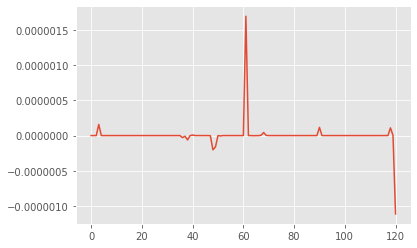

In [177]:
plt.plot(lasso_coef)

In [178]:
dominantFeatures = [x for index, x in enumerate(x_features) if abs(lasso_coef[index])>1e-08]

In [179]:
metadata[metadata['series_id'].isin(dominantFeatures)]

,series_id,name,units,type,month
None,,,,,
13427,A1827881R,-1 TOTAL,$ Millions,Original,1
20725,A416153A,Total value of building jobs ; Western Austra...,$'000,Original,1
21125,A577360A,Total value of building jobs ; New South Wale...,$'000,Original,1
23125,A3596731T,Value of building jobs valued $1 million to le...,$'000,Original,1
23325,A3596932L,"Value of building jobs valued $50,000 to less ...",$'000,Original,1
42061,A85248773V,Number of movements ; Argentina ; Short-term...,Number,Original,1
44477,A2413858L,4.1 . . . . . Electronic data processing equip...,$'000,Original,1
58805,A83901436A,>> 50-59 hours ; Number of hours actually wor...,000 Hours,Original,1
93730,A85316475X,Lending to households for investment dwellings...,$'000,Seasonally Adjusted,1


In [130]:
len(lasso_coef)

121

In [131]:
len(data.columns)

122

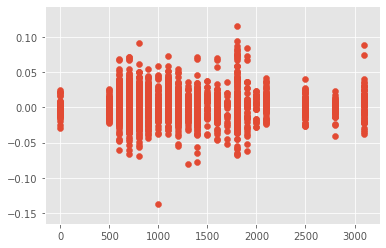

In [180]:
plt.scatter(data['A85375570W'], data['returns'])
